In [ ]:
## mostly fathon experiments on the latest code base

In [5]:
import os
import pandas as pd
import fathon
from fathon import fathonUtils as fu
import numpy as np
from collections import defaultdict

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb
###

# Plot settings
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
standard_scaler = StandardScaler()
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')
sys.path.append('/home/ak/Documents/PaperCode/stylised_facts')
import stylised_facts_data_utilities as sfd_utils
import lob_for_futures as lobfut
import mdfda.mdfda_experiments_utils as mdf
%matplotlib inline
import os

from scipy.stats import norm, ttest_ind

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
mpl.get_configdir()
# plot parametrisations
latex_styles = os.listdir(mpl.get_configdir())
plt.style.use(os.path.join(mpl.get_configdir(), latex_styles[1]))

In [8]:
def read_pkl_idx(files, file_idx):
    file_idx_loc = os.path.join(experimentsLocation, files[file_idx])
    dict_idx = pd.read_pickle(file_idx_loc)
    tick_ = dict_idx['tick']
    volume_ = dict_idx['volume']
    calendar_ = dict_idx['calendar']
    dollar_ = dict_idx['dollar']
    return tick_, volume_, calendar_, dollar_

In [9]:
laptop_OS_folder = '/media/ak/OS/Data/FuturesDataSemiProcessed'
LaCie_ProcessedData = '/media/ak/LaCie/ProcessedSampledData/'
# returns_data = '/media/ak/T7/August11th2022Experiments/Returns/'
t7 = '/media/ak/T71/'
# june_ext = os.path.join(t7, 'June4th2022Experiments')
# returns_data = [f for f in os.listdir(june_ext) if '_returns' in f]
experimentsLocation = '/media/ak/T71/August11th2022Experiments/'
bars =['tick', 'volume', 'calendar', 'dollar']

In [10]:
figures_destination = '/home/ak/Documents/Papers/StylisedFactsPaper/figures'

In [11]:
symbol = 'JB1'
symbol_files =[f for f in os.listdir(experimentsLocation) if str(symbol+'_tick') in f]
print(len(symbol_files))

138


In [12]:
file_idx = 100
file_idx_loc = os.path.join(experimentsLocation, symbol_files[file_idx])
file_idx_loc

'/media/ak/T71/August11th2022Experiments/JB1_tick_20180817_exp_df.pkl'

In [13]:
def read_exp_data(file_idx_):
    file_idx_loc_ = os.path.join(experimentsLocation, symbol_files[file_idx_])
    df_idx_ =  pd.read_pickle(file_idx_loc_)
    return df_idx_


In [14]:
dict_all_changes = dict()
for file_idx in range(0,138):
    dict_all_changes[file_idx] = read_exp_data(file_idx)['pct_change_micro_price']

In [11]:
df_all_pct_changes = pd.DataFrame.from_dict(dict_all_changes)

In [12]:
median_pct_change = df_all_pct_changes.median(axis=1).values

In [13]:
std_pct_change = df_all_pct_changes.std(axis=1).fillna(0).values

In [14]:
df_all_pct_changes.std(axis=1).describe()

count    3706.000000
mean        0.000083
std         0.000196
min         0.000000
25%         0.000037
50%         0.000053
75%         0.000072
max         0.002570
dtype: float64

In [15]:
# Experimental fathon functions

In [16]:

def to_agg(data):
    return fu.toAggregated(data)

def win_Sizes_len(data):
    return round(len(to_agg(data)), -2)

class mfdfaquantities(object):
    """
 winSizes : numpy ndarray
            Array of window's sizes.
        qList : float or iterable or numpy ndarray
            List of q-orders used to compute `F`.
        polOrd : int, optional
            Order of the polynomial to be fitted in every window (default : 1).
        revSeg : bool, optional
            If True, the computation of `F` is repeated starting from the end of the time series (default : False).
"""

    def __init__(self, data, winSizes, qs, revSeg, polOrd):
        self.data = data
        self.winSizes = winSizes
        self.qs = qs 
        self.revSeg = revSeg
        self.polOrd = polOrd        
        self.pymfdfa = fathon.MFDFA(self.data)
        
    def n_F_output(self):
        """
        # F : numpy ndarray
           Returns
            -------
            numpy ndarray
                Array `n` of window's sizes.
            numpy ndarray
                qxn array `F` containing the values of the fluctuations in every window for every q-order.
        """
        n, F = self.pymfdfa.computeFlucVec(self.winSizes, self.qs, self.revSeg, self.polOrd)
        return n, F


    def H_and_H_intcpt_output(self):
        """
        listH : numpy ndarray
        # Array containing the values of the slope of the fit at every q-order.
        # fit of the fluctuation values
                Returns
            -------
            numpy ndarray
                Slope of the fit for every q-order.
            numpy ndarray
                Intercept of the fit for every q-order.


        """
        list_H, list_H_intercept = self.pymfdfa.fitFlucVec()
        return list_H, list_H_intercept


    def compute_mass_exponents(self):
        tau = self.pymfdfa.computeMassExponents()
        return tau


    def compute_multi_fractal_spectrum(self):
        alpha, mfSpect = self.pymfdfa.computeMultifractalSpectrum()
        return alpha, mfSpect

    

In [17]:

data_median = to_agg(median_pct_change)


In [18]:



winSizes_1 = fu.linRangeByStep(10,win_Sizes_len(data_median)) # rounding length of t to the nearest 100

qs = np.arange(-3, 4, 0.1)
revSeg = True
polOrd = 1


In [19]:
testClass = mfdfaquantities(data_median, winSizes_1, qs, revSeg, polOrd )


In [20]:
# need to figure out how to parallelise this better
n, F  = testClass.n_F_output()
list_H, list_H_intercept = testClass.H_and_H_intcpt_output()
tau = testClass.compute_mass_exponents()
alpha, mfSpect = testClass.compute_multi_fractal_spectrum()

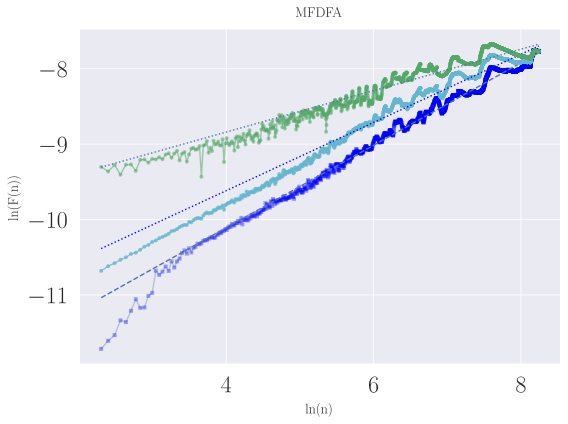

In [21]:


# list_H, list_H_intercept = pymfdfa.fitFlucVec()
plt.plot(np.log(n), np.log(F[0, :]), 'b',alpha =0.35,marker='s', markerfacecolor='blue',markeredgecolor='blue', markersize=4)

plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), 'b--', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)

plt.plot(np.log(n), np.log(F[half_idx, :]), 'c', alpha=0.75,marker='o', markersize=4)

plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         'b--', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]), color='blue',linestyle = ':')

plt.plot(np.log(n), np.log(F[-1, :]), 'g', alpha=0.55,marker='o', markersize=4)

plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), 'b:',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel("ln(n)", fontsize=14)
plt.ylabel("ln(F(n))", fontsize=14)
plt.title('MFDFA', fontsize=14)
# ## below for the plot saving
title_file = 'median_fluctuation_vs_window_size_for_symbol_'+str(symbol)+'pct_change_px.png'
fig_location = os.path.join(figures_destination, title_file)
plt.savefig(fig_location)
plt.show()

In [22]:
=plt.plot(np.log(n_tick), np.log(F_tick), 'ro')
_=plt.plot(np.log(n_tick), H_intercept_tick + H_tick*np.log(n_tick), '--', label='H tick = {:.2f}'.format(H_tick), color='red', linestyle = ':')



SyntaxError: invalid syntax (<ipython-input-22-5913d0f636ad>, line 1)

# to do: format plots

No handles with labels found to put in legend.


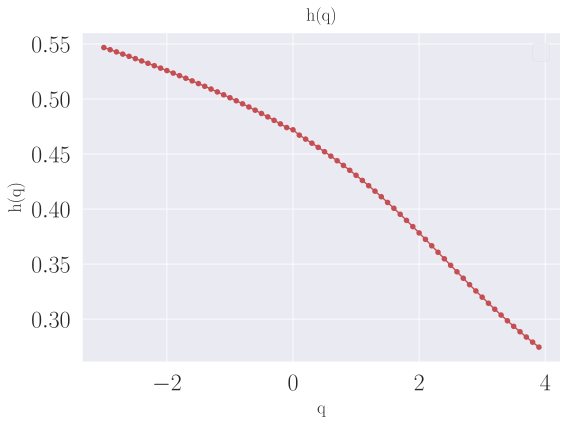

In [23]:
plt.plot(qs, list_H, 'ro-')
# plt.plot(qs, list_H_intercept, 'go-')

plt.xlabel('q', fontsize=18)
plt.ylabel('h(q)', fontsize=18)
plt.title('h(q)', fontsize=18)
plt.legend()
plt.show()

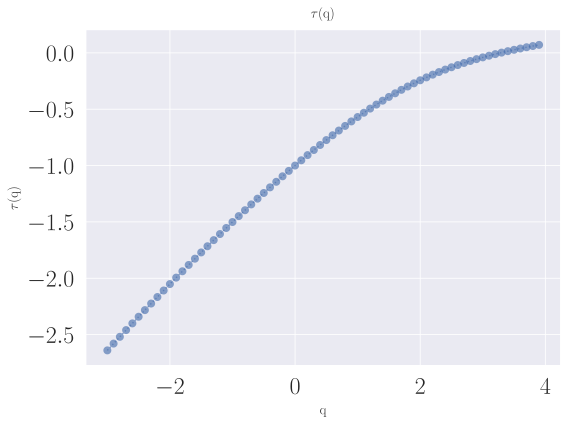

In [24]:

plt.plot(qs, tau, ':',marker='o', markeredgecolor ='black', alpha = 0.65, markersize =8)
# plt.plot(qs, tau, 'go-')

plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

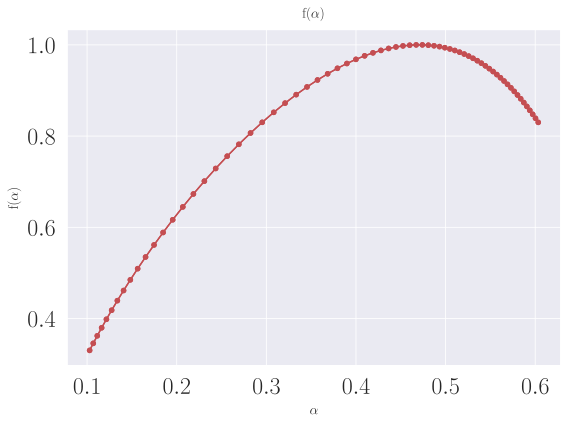

In [25]:

plt.plot(alpha, mfSpect, 'ro-')
plt.plot(alpha, mfSpect, 'ro-')

plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()

In [26]:
mpl.get_configdir()
# plot parametrisations
latex_styles = os.listdir(mpl.get_configdir())
latex_styles

['latexstyle2.mplstyle', 'latexstyle.mplstyle']

In [27]:
mpl.get_configdir()

'/home/ak/.config/matplotlib'

In [ ]:
symbol = 'RX1_'
symbol_files = [f for f in os.listdir(experimentsLocation) if str(symbol) in f]
print(len(symbol_files))
tick, volume, calendar, dollar = read_pkl_idx(symbol_files, 1)
raw_data = tick.pct_change_micro_price
data_input = mdf.to_agg(raw_data)
print(mdf.win_Sizes_len(raw_data))
print(len(data_input))
winSizes = fu.linRangeByStep(10, 20000)
qs = np.arange(-3, 4, 0.1)
revSeg = True
polOrd = 1
testClass = mdf.mfdfaquantities(data_input, winSizes, qs, revSeg, polOrd)
# # need to figure out how to parallelize this better
n, F = testClass.n_F_output()
list_H, list_H_intercept = testClass.H_and_H_intcpt_output()
tau = testClass.compute_mass_exponents()
alpha, mfSpect = testClass.compute_multi_fractal_spectrum()

print(alpha)

21
27800
27791


In [15]:
os.listdir(experimentsLocation)

['Returns',
 'ExperimentOne',
 'ExperimentTwo',
 'RX1_20180417_experiments_dict.pkl',
 'RX1_20180419_experiments_dict.pkl',
 'RX1_20180420_experiments_dict.pkl',
 'RX1_20180427_experiments_dict.pkl',
 'RX1_20180430_experiments_dict.pkl',
 'RX1_20180416_experiments_dict.pkl',
 'RX1_20180502_experiments_dict.pkl',
 'RX1_20180504_experiments_dict.pkl',
 'RX1_20180425_experiments_dict.pkl',
 'RX1_20180503_experiments_dict.pkl',
 'RX1_20180507_experiments_dict.pkl',
 'RX1_20180509_experiments_dict.pkl',
 'RX1_20180510_experiments_dict.pkl',
 'RX1_20180517_experiments_dict.pkl',
 'RX1_20180508_experiments_dict.pkl',
 'RX1_20180518_experiments_dict.pkl',
 'RX1_20180521_experiments_dict.pkl',
 'RX1_20180522_experiments_dict.pkl',
 'RX1_20180524_experiments_dict.pkl',
 'RX1_20180525_experiments_dict.pkl',
 'RX1_20180511_experiments_dict.pkl',
 'JB1_tick_20180509_exp_df.pkl',
 'JB1_tick_20180917_exp_df.pkl',
 'JB1_tick_20180628_exp_df.pkl',
 'JB1_tick_20180927_exp_df.pkl',
 'JB1_tick_20180425_ex

In [16]:
test_file = os.path.join(experimentsLocation, 'RX1_20180503_experiments_dict.pkl')

In [7]:
os.path.isfile(test_file)

True

In [20]:
## testing reading multiple files and putting them in one place for the Shogun Input

In [22]:
expOneLoc = os.path.join(experimentsLocation, 'ExperimentOne')
expOneFiles = os.listdir(expOneLoc)

mfdfa_keys = sorted(['n_F', 'list_H', 'list_H_intercept', 'tau', 'alpha', 'mfSpect'])
df_keys = sorted(['volume', 'tick', 'dollar', 'calendar'])
# ['calendar', 'dollar', 'tick', 'volume']
# ['alpha', 'list_H', 'list_H_intercept', 'mfSpect', 'n_F', 'tau']

In [23]:
calendar_files = [f for f in expOneFiles if str(df_keys[0]) in f]
dollar_files = [f for f in expOneFiles if str(df_keys[1]) in f]
tick_files =  [f for f in expOneFiles if str(df_keys[2]) in f]
volume_files = [f for f in expOneFiles if str(df_keys[3]) in f]

In [24]:
expOneFileIdx = 0

list_files_choice = tick_files
file_loc = os.path.join(expOneLoc, list_files_choice[expOneFileIdx])
file_loc

'/media/ak/T71/August11th2022Experiments/ExperimentOne/file7tick_mfdfa.pkl'

In [26]:
# pd.read_pickle(file_loc)['tick'][mfdfa_keys[0]] # this just reads one didct and converts it to dataframe

In [32]:
mfdfa_keys[0]

'alpha'

In [37]:
all_vars_dict = defaultdict(dict)
for i in range(0, len(list_files_choice)):
    file_loc = os.path.join(expOneLoc, list_files_choice[i])
    all_vars_dict[mfdfa_keys[0]][i] = pd.read_pickle(file_loc)['tick'][mfdfa_keys[0]]
    all_vars_dict[mfdfa_keys[1]][i] = pd.read_pickle(file_loc)['tick'][mfdfa_keys[1]]
    all_vars_dict[mfdfa_keys[2]][i] = pd.read_pickle(file_loc)['tick'][mfdfa_keys[2]]
    all_vars_dict[mfdfa_keys[3]][i] = pd.read_pickle(file_loc)['tick'][mfdfa_keys[3]]
    all_vars_dict[mfdfa_keys[4]][i] = pd.read_pickle(file_loc)['tick'][mfdfa_keys[4]]
    all_vars_dict[mfdfa_keys[5]][i] = pd.read_pickle(file_loc)['tick'][mfdfa_keys[5]]

    

In [52]:
alphas = pd.DataFrame.from_dict(all_vars_dict['alpha'])
mfSpect =  pd.DataFrame.from_dict(all_vars_dict['mfSpect'])

In [53]:
median_alphas  = alphas.median(axis=1).values # median_alpha_in_one place
median_mfspect  = mfSpect.median(axis=1).values # median_alpha_in_one place


In [54]:
median_alphas.shape

(69,)

In [55]:
median_mfspect

array([ 1.0505057 ,  1.05673481,  1.06226186,  1.06699799,  1.07088469,
        1.07389424,  1.07602694,  1.07730589,  1.07777098,  1.07747271,
        1.07646688,  1.07481038,  1.07255819,  1.06976176,  1.06646839,
        1.06272178,  1.05856328,  1.05403407,  1.04917786,  1.04404432,
        1.03869286,  1.03319681,  1.02764772,  1.0234936 ,  1.01908041,
        1.01444693,  1.00945817,  1.00503579,  1.00178339,  1.        ,
        1.        ,  1.00206495,  1.00636075,  1.01281233,  1.0209349 ,
        1.02963435,  1.01674735,  0.99924106,  0.99427719,  0.99253312,
        0.97393753,  0.93060621,  0.85471296,  0.7586531 ,  0.64756381,
        0.52942011,  0.41326029,  0.3069841 ,  0.21573616,  0.14148704,
        0.08365174,  0.04013456,  0.01079714, -0.0021142 , -0.01053952,
       -0.0135347 , -0.01310163, -0.01269057, -0.01230018, -0.01666436,
       -0.02025344, -0.0203573 , -0.02039257, -0.02038589, -0.02035441,
       -0.02030898, -0.02025628, -0.02016825, -0.01995114])

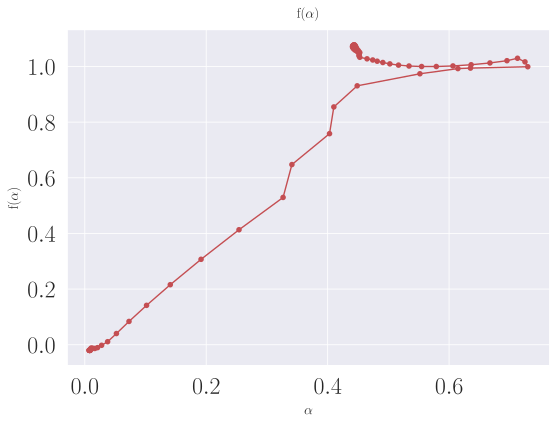

In [57]:
plt.plot(median_alphas, median_mfspect, 'ro-')

plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()